# **Time Series Analysis**

We will now conduct some basic time series prediction techniques on our data. We will load our similar to the `exploratory_data_analysis` notebook.

In [1]:
# Data Management
import pandas as pd 
from tqdm import tqdm
import numpy as np
# Statistics
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
# Graphics
from matplotlib import pyplot as plt

TSA_DATA_PATH = '../data/tsa_checkins.csv'

In [2]:
# Loading data
checkin_data = pd.read_csv(TSA_DATA_PATH)
# removing covid data
checkin_data['Date'] = pd.to_datetime(checkin_data['Date'])
restrictions_start = '2/2/2020'
restrictions_end = '11/8/2021'
checkin_data = checkin_data[(checkin_data['Date'] < restrictions_start) | (checkin_data['Date'] > restrictions_end)]
checkin_data = checkin_data.set_index('Date')

## Autocorrelation and Partial Autocorrelation Function

#### PACF vs ACF

To understand the partial autocorrelation function (PACF), we must first understand the autocorrelation function (ACF). The ACF is a measure of how much 'effect' one time lag may have on another. For example, let's look at the following three lags

In [3]:
# +---------------------+
# |                     |
# t - 2 ---> t - 1 ---> t

We can see that the time lag previous *directly* affects the current lag. We can also see that the time lag from two periods ago *directly* affects the current lag. However, this `t-2` lag also *indirectly* affects our `t` lag. This is because `t-2` affects `t-1` which affects `t`.

The ACF function is essentially the normal pearson corrleation coefficient between `{t,t-1}` and `{t,t-2}` which will account for the *indirect* effect as well as the direct. 

The PACF will instead just focus on the *direct* relationship between the respective pair of lags. We utilize the PACF because the ACF value can be misleading. The `t-2` lag may seem like a useful predictor only because its indirect affect (and therefore really just the `t-1` lag). By just focusing on the direct effect we figure which lags are truly best. 

#### Deriving the PACF 

We can derive the PACF using the *conditional correlation coefficient* or through regresssion. 

Finding the PACF for $t_{i-3}$ with the *conditional correlation coefficient* method would yield...

$Cov(t_i, t_{i-3} | t_{i-1}, t_{i-2}) \over{\sigma_{t_i | t_{i-1}, t_{i-2}} \sigma_{t_{i-3} | t_{i-1}, t_{i-2}}}$

We can generalize this for how many ever terms but we are essentially finding the correlation of this term (in our example $t_{i-3}$) with the current, given that we already know the affect of all future lags. 

Using regression...

Let's again start with $t_{i-2}$. We first start by fitting a model to predict $t_i$ based on just $t_{i-1}$. We find 

$t_i = \beta_{0} + \beta_{1} t_{i-1} + \epsilon$

where $\epsilon$ is a white noise. We know that not all of $t_i$ can be explained by just $t_{i-1}$ and so the remaining must be the direct correlation of $t_{i-2}$ or 

$t_i = \beta_{0} + \beta_{1} t_{i-1} + \beta_{2} t_{i-2} + \epsilon$

**NOTE**: this is overly simplified as the current lag would likely need many more previous lags to explain its value. We would generalize this concept to as many lags as we need. 

#### Visualizing the ACF and PACF

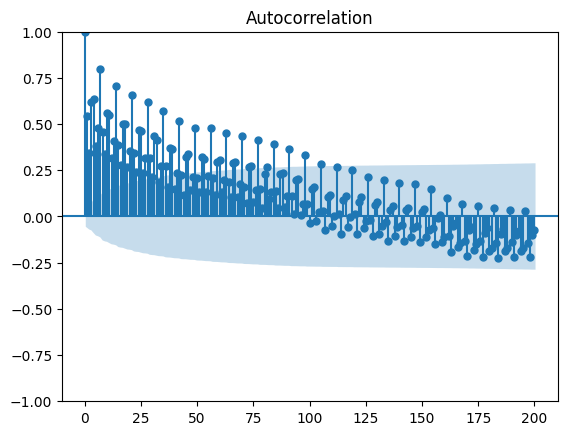

In [10]:
plot_acf(checkin_data['Checkins'], lags=200)
plt.show()

We see that the lags have very strong correlation with their most previous values and another spike at around 365 lags ago (a year ago). 

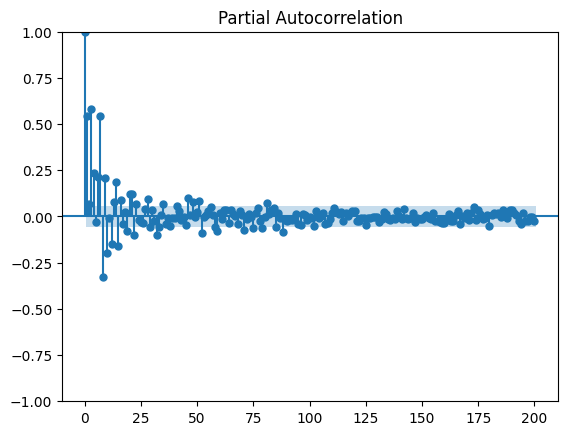

In [11]:
plot_pacf(checkin_data['Checkins'], lags=200)
plt.show()

We see correlation between lags which means that we can deploy a regressive model for prediction. We can see huge significance in the first 7-8 terms. We note that the ACF does not seem to just 'shut off' meaning that a MA model would likely not suffice. From these plots we can see that the ACF and PACF functions geometrically decay meaning an ARIMA type model is likely most beneficial. 

## Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

#### Autoregressive (AR) Models

Autoregressive models are an attempt to predict future values of a data by using past values of the data only. In a multiple regression, we take a linear combination of predictor. However, in an *autoregression* we just just use *past value* for the regression. An auto regressive model of order $p$ with error term $\epsilon$ 

$y_t = c + \phi_{1} y_{t-1} + \phi_{2} y_{t-2} + ... + \phi_{p} y_{t-p} + \epsilon_{t}$

A naive approach is to use all past lagged values. However this typically results in an overfit model. REMEMBER, we ALWAYS prefer a simpler model (that can accomplish the same thing) in statistics. We will only choose lags with a significant enough PACF value (seen outside of the blue box). A basic autoregressive model works best on a stationary dataset. 

#### Moving Averages (MA) Models

A moving average uses *past forecast errors* in a regression style model. We create a moving average of order $q$ with

$y_t = c + \epsilon_{t} + \theta_{1} y_{t-1} + \theta_{2} y_{t-2} + ... + \theta_{q} y_{t-q}$

Let's think about a very simple MA that we describe as

$f_t = \mu + \phi_{1}\epsilon_{1}$

where $\mu = 10$ and $\phi_{1} = 0.5$. This is saying change from the baseline by 50% of the last error. For example if we predicted $10$ and the actual value was $12$ then our model's error was $2$ so we would predict $10 + 0.5 \times 2 = 11$

#### Invertibility



We can model any $AR(p)$ model as an $MA(\infty)$ model. Let's show an $AR(1)$ model 

$y_t = \phi_{1} y_{t-1} + \epsilon_{t}$

=  $\phi_{1} (\phi_{1} y_{t-2} + \epsilon_{t-1}) + \epsilon_{t}$

= $\phi_{1}^2 y_{t-2} + \phi_{1} \epsilon_{t-1} + \epsilon_{t}$

Similarly, we can show that $MA(1)$ is the same as $AR(\infty)$ model so long as $|\phi| < 1$. Note that $L$ is the lag operator

$y_t = \phi\epsilon_{t-1} + \epsilon_{t}$ 

$ = (1 - \phi L)\epsilon$

${y_t \over{1 - \phi L}}  = \epsilon$ 

But note that $1 \over{1 - \phi L}$ is just the summation of an infinite geometric series with $ r = -\phi L$ and therefore 

$(1 + \phi L + \phi^2 L^2 + ...)y_t = \epsilon_t$

$y_t = - \phi y_{t-1} - \phi^2 y_{t-2} + ... + \epsilon_t$

This is a much more useful approach for the $MA(q)$ model as, in reality, it may be hard to see how much of our forecast was wrong due to error in real time. Instead, we can represent our MA using the equivalent model with previous lags, shutting off after we raise $\phi$ to a high enough order as $|\phi| < 1$ 

#### Integrating

Since our data is not stationary, we cannot take advantage of the AR or MA concepts above. However, we can transform our data to make it stationary through integration. By integration we mean differencing lags and predicting the series of the differences. 

$z_t = y_{t+1} - y_t$

We typically will not go beyond a first or second order differencing. We can figure out the timelag's value through our predicted $\hat{z_t}$

$y_{t+1} = \hat{z_t} + y_t$

#### Seasonality

Seasonality is a characteristic of timeseries data. It is when the data repeats itself within a year in a predictable fashion. We can remove seasonality through differencing lags that are a year apart. This means 

$z_t = y_t - y_{t-365}$

c:\Users\neili\Desktop\Kalshi-Strategies\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\neili\Desktop\Kalshi-Strategies\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\neili\Desktop\Kalshi-Strategies\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\neili\Desktop\Kalshi-Strategies\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

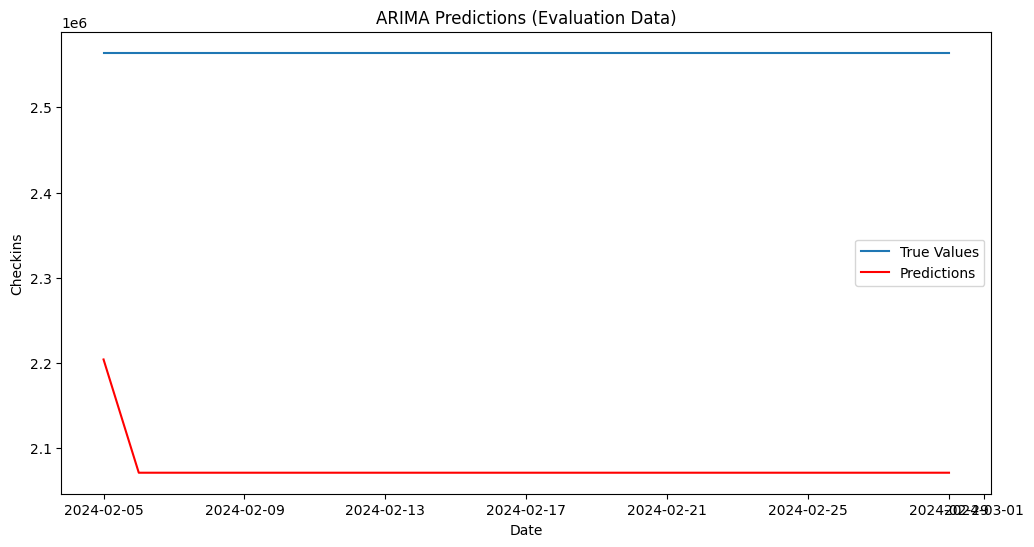

In [8]:
tqdm.pandas()

# Split data into training and evaluation sets
train_size = int(len(checkin_data) * 0.80)  # 80% for training
train_data = checkin_data.iloc[:train_size]
eval_data = checkin_data.iloc[train_size:]

# Initialize lists to store predictions and true values
predictions = []
true_values = []

# Fit ARIMA model using training data
model = ARIMA(np.array(train_data['Checkins']), order=(20, 1, 1))  # Including differencing (d=1)
fitted_model = model.fit()

# Iterate over evaluation data
for index in tqdm(range(train_size, len(checkin_data))):
    # Make one-step-ahead forecast
    forecast = fitted_model.forecast(steps=1)
    predicted_value = forecast[0]  # Accessing the forecasted value from the tuple
    
    # Append prediction and true value to lists
    predictions.append(predicted_value)
    true_value = checkin_data.iloc[1178]['Checkins']
    true_values.append(true_value)
    
    # Update model with true value
    fitted_model = ARIMA(np.append(train_data['Checkins'], true_value), order=(20, 1, 1)).fit()

# Plot original evaluation data and predictions
plt.figure(figsize=(12, 6))
plt.plot(eval_data.index, true_values, label='True Values')
plt.plot(eval_data.index, predictions, label='Predictions', color='red')
plt.title('ARIMA Predictions (Evaluation Data)')
plt.xlabel('Date')
plt.ylabel('Checkins')
plt.legend()
plt.show()


In [9]:
import numpy as np

def mean_absolute_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Calculate error metrics
mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = root_mean_squared_error(true_values, predictions)
mape = mean_absolute_percentage_error(true_values, predictions)

# Print error metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Error (MAE): 487255.5110448976
Mean Squared Error (MSE): 238095466124.01306
Root Mean Squared Error (RMSE): 487950.2701341737
Mean Absolute Percentage Error (MAPE): 19.004006730399965


## Sources 

**Autocorrelation and Partial Autocorrelation Function**

[`1`] https://www.youtube.com/watch?v=DeORzP0go5I&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=2

ritvikmath youtube which is helpful for understanding what the PACF is 

[`2`] https://timeseriesreasoning.com/contents/partial-auto-correlation/ 

Timeseries reasoning blog. Mainly used for deriving the actual formula 

[`3`] https://www.youtube.com/watch?v=XESy8JImWr0

OK youtube for understanding the PACF, helpful first understanding conditional correlation coefficient

[`4`] https://www.youtube.com/watch?v=-vSzKfqcTDg

Analytics University youtube on how to utilize the ACF and PACF plots

**Autoregressive Integrated Moving Average (ARIMA) Model**

[`1`] https://www.youtube.com/watch?v=5-2C4eO4cPQ&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=9

ritvikmath overview of the autoregressive model 

[`2`] https://otexts.com/fpp2/arima.html

Basic overview of an ARIMA model

[`3`] https://online.stat.psu.edu/stat510/ 
Excellent overview of time series analysis by Penn State. Lessons 2-3 relevant to this section